In [1]:
import datetime
from os import path
import math
import collections
import numpy as np
np.set_printoptions(formatter={'float_kind':"{:-.3e}".format})
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal as signal
import core as co
import sys

In [2]:
import hist_data as hd

hd.set_hist_data(data_count=None)


forecast:
direction: buy-sell
min profit [PIP]: 7.51
panic value [PIP]: -0.50 - no panic



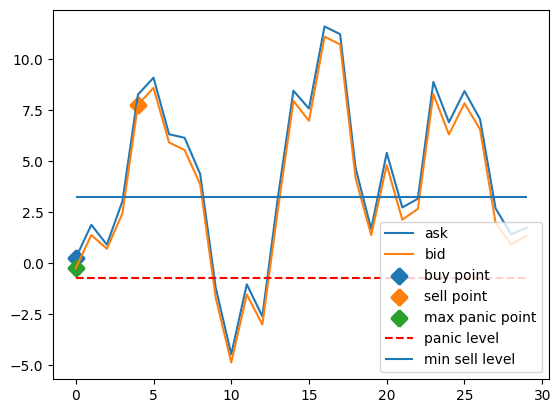

In [3]:
import importlib
import tokenizer as to
import forecast as fo
importlib.reload(fo)
import piecewise_fit as ls
importlib.reload(ls)
importlib.reload(co)

FORECAST_WINDOW = 30
FORECAST_THRESHOLD = 2e-4 + 1e-4 # spread

shift = 1000 # 1400 1500
forecast = fo.Forecast(
    hd.DATA[shift: FORECAST_WINDOW + shift], 
    threshold=FORECAST_THRESHOLD)
print(forecast)
forecast.plot(True)
# [0.000114, 0.000227, 0.000455, 0.00091, 0.00182, 0.00364, 0.00728, 0.0146]


In [79]:
FORECAST_THRESHOLD = co.config.FORECAST_THRESHOLD
PANIC_THRESHOLD = co.config.PANIC_THRESHOLD
FORECAST_WINDOW = co.config.FORECAST_WINDOW
RISK_FACTOR = 0.7

In [80]:
dict_data = hd.ForexProvider()
oracle = fo.Oracle(dict_data)

In [81]:
def prices(data):
    # 
    timestamp, (timestamp, (ask, bid), volume)  = data
    # print((ask[0], bid[0]))
    return ask[0], bid[0]

def sell_buy(ask_price, bid_price, plot=False):
    """
    bid price == sell price
    ask price == buy price
    """
    sell_price = bid_price
    profit =  sell_price - ask_price

    bid_prices = [bid_price]
    ask_prices = [ask_price]
    profits = [profit]
    time = 0
    times = [time]

    max_profit = None
    def strategy(profit):
        nonlocal max_profit
        if max_profit is None:
            return False
        
        max_profit = max(max_profit, profit)
        return profit < max_profit * RISK_FACTOR


    while True: # buy (ask) low
        ask_price, bid_price = prices(next(dict_data))
        profit = sell_price - ask_price

        bid_prices.append(bid_price)
        ask_prices.append(ask_price)
        profits.append(profit)
        time += 1
        times.append(time)

        '''
        First step is to reach the predicted minimal profit level, but abort if
        the predictec panic level is passsed.
        '''
        if (profit >= FORECAST_THRESHOLD) and max_profit is None:
            max_profit = -sys.float_info.max
        if strategy(profit):
            break

    if plot:
        fig, bidask_pl = plt.subplots()
        # print(bid_prices)
        # print(ask_prices)
        bidask_pl.plot(times, bid_prices, color='blue', label='bid')
        bidask_pl.plot(times, ask_prices, color='red', label='ask')

        profit_pl = bidask_pl.twinx()
        profit_pl.hlines(FORECAST_THRESHOLD, times[0], 
                         times[-1], color='black', linestyle='--', label='min. profit')
        profit_pl.plot(times, profits, color='green', label='profit')
        
        bidask_pl.set_ylabel('bid, ask', color='black')
        profit_pl.set_ylabel('profit, min. profit, panic', color='green')

        bidask_pl.legend()
        profit_pl.legend()
        plt.show()

    return profit

def buy_sell(ask_price, bid_price, plot=False):
    buy_price = ask_price
    sell_price = bid_price
    profit = buy_price - sell_price
    while True:
        break



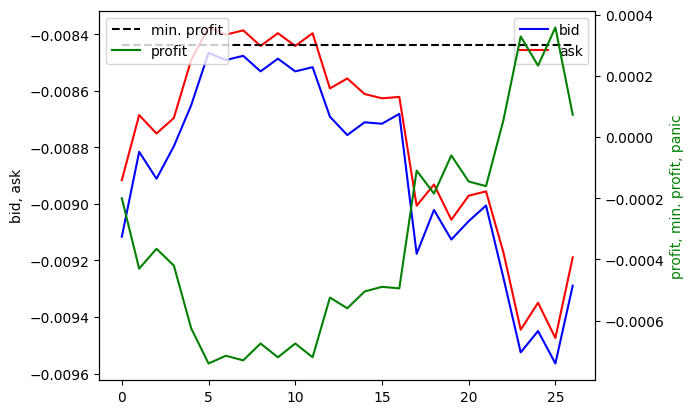

profit: 0.7


In [84]:
while True:
    timestamp_data = next(dict_data)
    if timestamp_data[0] not in oracle.predictions():
        continue
    
    ask_price, bid_price = prices(timestamp_data)
    _, (advice, trans_time, panic, max_panic_time) = oracle.prediction()
    plot = True
    if advice == fo.Forecast.advices[fo.Forecast.IS_ASK]:
        print(f'profit: {sell_buy(ask_price, bid_price, plot=plot) / fo.Forecast.PIP:.1f}')
        break
    elif advice == fo.Forecast.advices[fo.Forecast.IS_BID]:
        buy_sell(ask_price, bid_price, plot=plot)
    else:
        pass


## GamblerSimple

In [112]:
import gambler_simple as gs
_ = importlib.reload(hd)
_ = importlib.reload(fo)
_ = importlib.reload(gs) 

In [55]:
hd.set_hist_data(data_count=None)
oracle = fo.Oracle(hd.ForexProvider())

advice: sell-buy, profit: 4.3e-04, min. profit: 3.0e-04


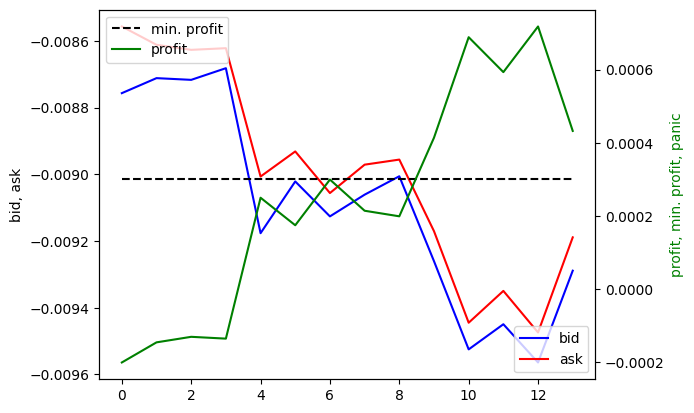

In [58]:
g = gs.gambler(forex_prediction=oracle.prediction, plot=True)

In [ ]:
hd.set_hist_data(data_count=None, verbose=False)
oracle = fo.Oracle(hd.ForexProvider())

profits = []
timestamps = []
times = []

while True:
    g = gs.gambler(forex_prediction=oracle.prediction, min_profit=3e-4, risk_factor=0.8)
    if (g is None) or g.endofdata:
        break
    profits.append(g.profit)
    timestamps.append(g.timestamp)
    times.append(g.times[-1])

Test data size (flats are duducted) is 677512
Test data start time is 2023:01:03 21:34
Test data end time is   2024:10:25 19:00
Subtracting moving avarage: True
END OF DATA


In [114]:
trans_count = len(profits)
profits = np.array(profits)
total = sum(profits)
print(f'trans. count: {trans_count}')
print(f'total profit: {total:.1e}')
print(f'mean profit: {total / trans_count:.1e}')


trans. count: 27508
total profit: 1.0e+01
mean profit: 3.8e-04


min_profit=4e-3, risk_factor=0.8
trans. count: 22
total profit: 8.7e-02
mean profit: 4.0e-03

min_profit=3e-4, risk_factor=0.8
trans. count: 27508
total profit: 1.0e+01
mean profit: 3.8e-04

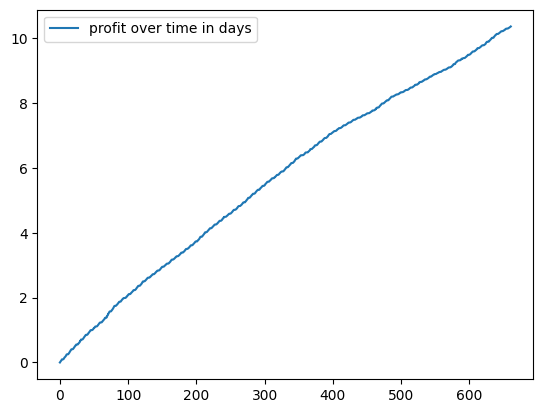

In [115]:
cumprofit = profits.cumsum()
timestamps = np.array(timestamps)
days = (timestamps - timestamps[0]) / 60 / 60 / 24
plt.plot(days, cumprofit, label='profit over time in days')
plt.legend()
plt.show()

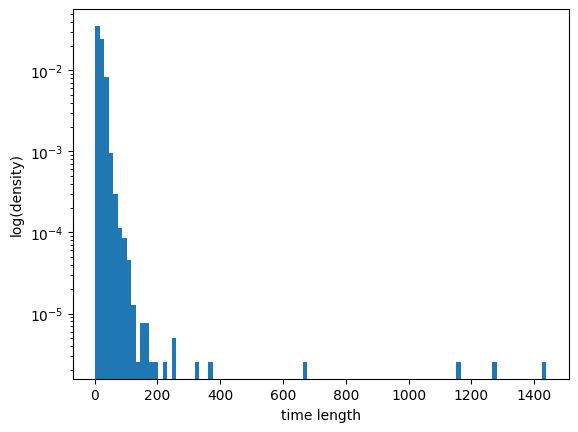

In [116]:
plt.hist(times, bins=100, density=True, log=True)
plt.xlabel('time length')
plt.ylabel('log(density)')
plt.show()

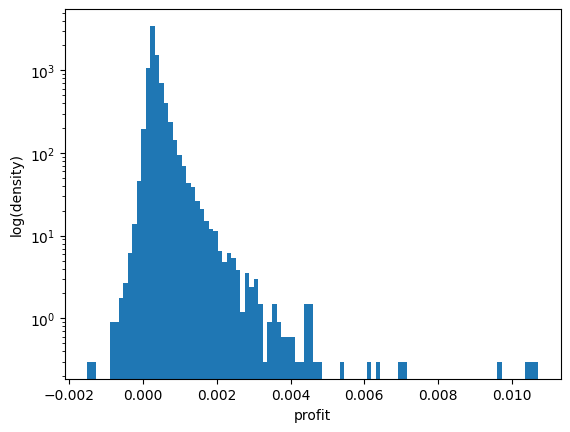

In [117]:
plt.hist(profits, bins=100, density=True, log=True)
plt.xlabel('profit')
plt.ylabel('log(density)')
plt.show()